In [1]:
pwd

'/data2/mito_lineage/src/vireo'

In [2]:
import os
#os.chdir("/data2/mito_lineage")

In [3]:
from os.path import join, exists, dirname
from glob import glob
import pickle
import mplh.cluster_help as ch
import os
import vireoSNP
import numpy as np
from scipy import sparse
from scipy.io import mmread
import matplotlib.pyplot as plt
from scipy.stats import hypergeom
print(vireoSNP.__version__)

import pandas as pd
import seaborn as sns
from vireoSNP import Vireo
np.set_printoptions(formatter={'float': lambda x: format(x, '.5f')})

from src.external.pyvenn import venn

%load_ext autoreload
%autoreload 2
import src.utils.variant_utils as vu
from src.utils.data_io import wrap_load_mtx_df

0.4.2


In [4]:
#dat_indir="data/CHIP_april08_2021/MTblacklist/chrM/pseudo/minC200_minAF0.01/numC100000_ispropFalse/"
INDIR="data/processed/mttrace/CHIP_april08_2021_Croker/MTblacklist/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/filter_mgatk/vireoIn/multiplex"
OUTDIR="data/processed/mttrace/CHIP_april08_2021_Croker/MTblacklist/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/filter_mgatk/vireoIn/variants"
#OUTDIR= "data/CHIP_april08_2021/MTblacklist/chrM/pseudo/minC200_minAF0.01/numC100000_ispropFalse/variants"
N_DONORS=5 
vars_to_plot=50
#dat_indir=""
sample_names="Control,Flt3l,Input"
n_clones=20

In [5]:
dat_indir = os.path.dirname(INDIR)#, "multiplex")
out_f = os.path.join(OUTDIR, f"variants_violin_top{vars_to_plot}")

In [6]:
sample_names = {ind:val for ind,val in enumerate(sample_names.split(","))}
#if not os.path.exists(OUTDIR):
#    os.mkdir(OUTDIR)
cells_meta = pd.read_csv(join(INDIR, "cells_meta.tsv"), sep='\t')
cells_meta=cells_meta.astype({"donor_index": "Int64", "donor": "Int64"})
cells_meta.head()

,new index,ID,raw ID,condition,donor,donor_index
0,1,AAACGAATCTTACTCA-1_Input,AAACGAATCTTACTCA-1,Input,0,1
1,2,AAAGGATAGTCGTGAG-1_Input,AAAGGATAGTCGTGAG-1,Input,2,1
2,3,AAATGAGGTCAATACC-1_Input,AAATGAGGTCAATACC-1,Input,NaN,NaN
3,4,AAATGCCAGGAACCGT-1_Input,AAATGCCAGGAACCGT-1,Input,4,1
4,5,AAATGCCCACCGAAAG-1_Input,AAATGCCCACCGAAAG-1,Input,NaN,NaN
...,...,...,...,...,...,...
4793,4794,TTTGTGTCATTCTTTG-1_Flt3l,TTTGTGTCATTCTTTG-1,Flt3l,0,1136
4794,4795,TTTGTGTTCAAGAGGC-1_Flt3l,TTTGTGTTCAAGAGGC-1,Flt3l,0,1137
4795,4796,TTTGTGTTCGCAGATT-1_Flt3l,TTTGTGTTCGCAGATT-1,Flt3l,1,788
4796,4797,TTTGTGTTCGCTATAG-1_Flt3l,TTTGTGTTCGCTATAG-1,Flt3l,3,949


## Load and clean variants vcf

In [7]:
vcf = pd.read_csv(join(dat_indir, "cellSNP.base.vcf"),sep='\t')
vcf_samp_dict = {}
for s in sample_names:
    col = vcf.columns.values[vcf.columns.str.contains(sample_names[s])]
    vcf_samp_dict[col[0]]=sample_names[s]
vcf = vcf.rename(vcf_samp_dict, axis=1)
vcf

,index_x,#CHROM,POS,REF_x,ALT,strand_correlation_x,vmr_x,n_cells_over_5_x,n_cells_over_20_x,Input,...,n_cells_over_20_y,Control,index,REF,strand_correlation,vmr,n_cells_over_5,n_cells_over_20,Flt3l,new ID
0,73A>G,chrM,73,73A,G,0.996919,0.382955,119.0,116.0,1.0,...,329.0,2.0,73A>G,73A,0.995236,0.339875,2768.0,2699.0,3.0,1
1,146T>C,chrM,146,146T,C,0.993106,0.591151,2.0,1.0,2.0,...,NaN,NaN,146T>C,146T,0.990833,0.665951,15.0,6.0,6.0,2
2,150C>T,chrM,150,150C,T,0.979327,0.670372,61.0,49.0,3.0,...,177.0,3.0,150C>T,150C,0.977151,0.800561,714.0,664.0,9.0,3
3,195T>C,chrM,195,195T,C,0.990257,0.623396,44.0,31.0,4.0,...,22.0,4.0,195T>C,195T,0.971955,0.669470,1103.0,1027.0,11.0,4
4,248A>G,chrM,248,248A,G,0.705534,4.216593,24.0,14.0,5.0,...,88.0,5.0,248A>G,248A,0.898661,1.701709,242.0,222.0,13.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,NaN,chrM,16356,NaN,A,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,16356T>A,16356T,0.951078,0.014387,0.0,0.0,363.0,491
491,NaN,chrM,16362,NaN,G,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,16362T>G,16362T,1.000000,0.012836,0.0,0.0,365.0,492
492,NaN,chrM,16387,NaN,G,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,16387A>G,16387A,0.889789,0.013112,0.0,0.0,366.0,493
493,NaN,chrM,16512,NaN,A,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,16512T>A,16512T,0.946026,0.015040,0.0,0.0,367.0,494


variants
['7373A>G' '146146T>C' '150150C>T' '195195T>C' '248248A>G' '287N>C'
 '310310T>C' '347N>T' '368N>G' '477477T>C' '489489T>C' '499499G>A'
 '514N>A' '515515A>G' '523523A>C' '709709G>A' '875N>C' '892N>C'
 '930930G>A' '10821082A>G' '1130N>T' '1134N>A' '1174N>C' '1252N>A'
 '1291N>C' '1589N>G' '1811N>T' '18111811A>G' '1876N>G' '18881888G>A'
 '2017N>A' '20832083T>C' '22312231A>G' '2264N>G' '25292529T>C'
 '26232623A>G' '2651N>G' '27022702G>A' '27062706A>G' '2707N>G' '2871N>C'
 '2875N>T' '28752875A>G' '30103010G>A' '3106N>A' '31443144A>G' '3203N>G'
 '32443244G>A' '3412N>A' '3488N>C' '35523552T>A' '3561N>C' '36723672A>G'
 '41174117T>C' '42164216T>C' '4428N>A' '4516N>A' '46464646T>C'
 '47154715A>G' '4831N>A' '49174917A>G' '51475147G>A' '52525252G>A'
 '5335N>G' '5361N>C' '5370N>C' '54965496A>G' '55805580T>C' '5600N>C'
 '5610N>A' '5622N>T' '5698N>A' '59995999T>C' '60476047A>G' '6050N>C'
 '6221N>C' '6513N>A' '6529N>G' '6795N>A' '70287028C>T' '7066N>G'
 '71587158A>G' '71967196C>A' '75897589G>A

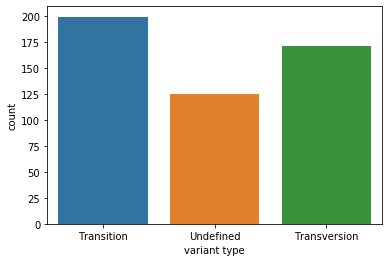

In [8]:
%matplotlib inline
vcf['ID'] = vcf.fillna("N").apply(lambda x: str(x["POS"]) + x['REF']+">"+x['ALT'], axis=1)

variant_df = vu.type_of_variants(vcf['ID'].values)
variant_positions = list(map(lambda x: int(x[:-3]), vcf['ID']))
variant_df["ID"] = np.arange(len(variant_df))

sns.countplot(x=variant_df['variant type'])

## Get overlap variants based on the vireo algorithm

## Plot

In [9]:
samples = list(sample_names.values())
variant_overlaps=dict()
for s in samples:
    variant_overlaps[s] = set(vcf[s].loc[(~(vcf[s].isnull()))].index.values)

{'Control': {0,
  2,
  3,
  4,
  6,
  9,
  10,
  11,
  13,
  14,
  15,
  18,
  19,
  27,
  29,
  31,
  38,
  42,
  43,
  44,
  45,
  50,
  51,
  52,
  53,
  54,
  57,
  58,
  60,
  61,
  62,
  64,
  66,
  67,
  72,
  73,
  79,
  81,
  82,
  83,
  84,
  85,
  86,
  91,
  92,
  93,
  95,
  96,
  106,
  107,
  109,
  111,
  112,
  113,
  114,
  116,
  118,
  120,
  122,
  123,
  124,
  125,
  129,
  131,
  132,
  135,
  136,
  137,
  138,
  144,
  145,
  152,
  154,
  156,
  157,
  158,
  160,
  161,
  163,
  165,
  168,
  169,
  170,
  171,
  173,
  174,
  176,
  177,
  178,
  179,
  180,
  182,
  183,
  184,
  185,
  186,
  187,
  188,
  189,
  190,
  191,
  196,
  197,
  198,
  199,
  200,
  201,
  202,
  203,
  204,
  205,
  206,
  207,
  208,
  209,
  210,
  211,
  212,
  213,
  214,
  215,
  216,
  217,
  218,
  219,
  220,
  221,
  222,
  223,
  224,
  225,
  226,
  227,
  228,
  229,
  230,
  231,
  232,
  233,
  234,
  235,
  236,
  237,
  238,
  239,
  240,
  241},
 'Flt3l': {0,

(<Figure size 864x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f757012d5f8>)

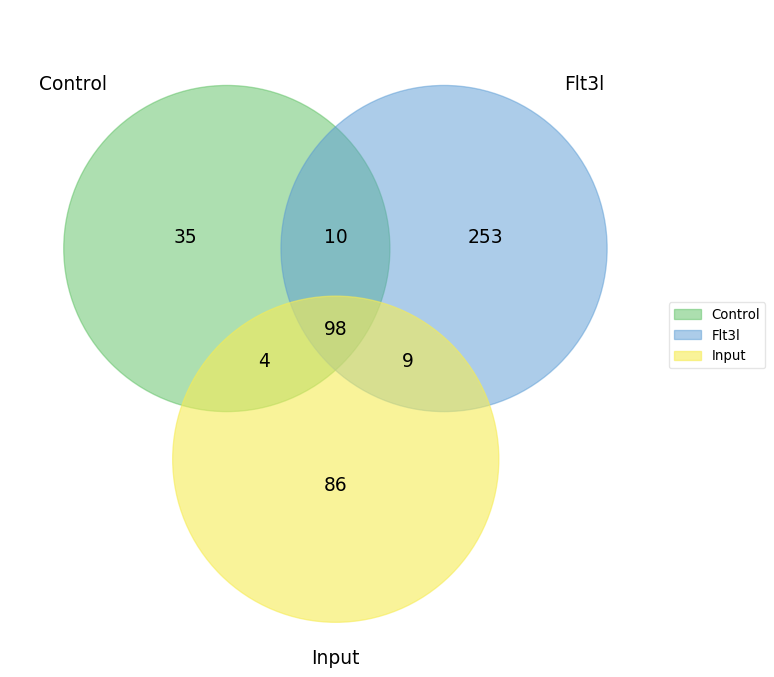

In [10]:
%matplotlib inline
labels=venn.get_labels(list(variant_overlaps.values()))
if len(samples) == 2:
    venn.venn2(labels=labels ,names=samples)
elif len(samples) == 3:
    venn.venn3(labels=labels ,names=samples)
elif len(samples) == 4:
    venn.venn4(labels=labels ,names=samples)
else: "Too many conditions to plot overlaps"

## Break up by donor and plot

### Load AD , DP  and convert variants to dense

In [11]:
# ad, dp = wrap_load_mtx_df(dat_indir, oth_f=False, prefix="cellSNP.tag",
#                      columns=('Variant', 'Cell', 'integer'))

AF_df, DP_df = wrap_load_mtx_df(dat_indir, oth_f=False, prefix="cellSNP.tag",
                     columns=('Variant', 'Cell', 'integer'), inc_af=True, as_dense=True, var_names=True)

variant_df = vu.type_of_variants(AF_df.index)

variants_box=vu.variants_dense(AF_df, vars_to_plot, samples_d=cells_meta['condition'], donors_d=cells_meta['donor'],
                              variant_d=variant_df['variant type'])
variants_box

cellSNP.tag
skipping 0 rows
  index_x #CHROM  POS REF_x ALT  strand_correlation_x     vmr_x  \
0   73A>G   chrM   73   73A   G              0.996919  0.382955   
1  146T>C   chrM  146  146T   C              0.993106  0.591151   
2  150C>T   chrM  150  150C   T              0.979327  0.670372   
3  195T>C   chrM  195  195T   C              0.990257  0.623396   
4  248A>G   chrM  248  248A   G              0.705534  4.216593   

   n_cells_over_5_x  n_cells_over_20_x  \
0             119.0              116.0   
1               2.0                1.0   
2              61.0               49.0   
3              44.0               31.0   
4              24.0               14.0   

   old data/processed/mttrace/CHIP_april08_2021_Croker/MTblacklist/Input/MT/cellr_True/Input_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/filter_mgatk/vireoIn  \
0                                                1.0                                                                                   

,Variant,Cell,AF,condition,donor,sqrtAF,variant type
0,1651916519T>C,0,0.001561,Input,0,0.039513,Transition
1,310310T>C,0,0.999323,Input,0,0.999661,Transition
2,27062706A>G,0,0.992202,Input,0,0.996093,Transition
3,7373A>G,0,0.988295,Input,0,0.994130,Transition
4,1171911719G>A,0,0.987536,Input,0,0.993748,Transition
...,...,...,...,...,...,...,...
239895,77057705T>C,4797,0.000000,Flt3l,1,0.000000,Transition
239896,31443144A>G,4797,0.000000,Flt3l,1,0.000000,Transition
239897,60476047A>G,4797,0.000000,Flt3l,1,0.000000,Transition
239898,28752875A>G,4797,0.000000,Flt3l,1,0.000000,Transition


## Plots
### a. Line plot across conditions (top 50)
x = condition (ordered as first, last, middle  
y = mean AF (and variance?)  
column = donors


### b. Line plot across donors (top 50)
x=donors
y=mean af
columns=condition

### c. Transition-transversion violinplot meanAF each column is a donor


In [12]:
variants_box = variants_box.dropna() # removes the ambiguous donors

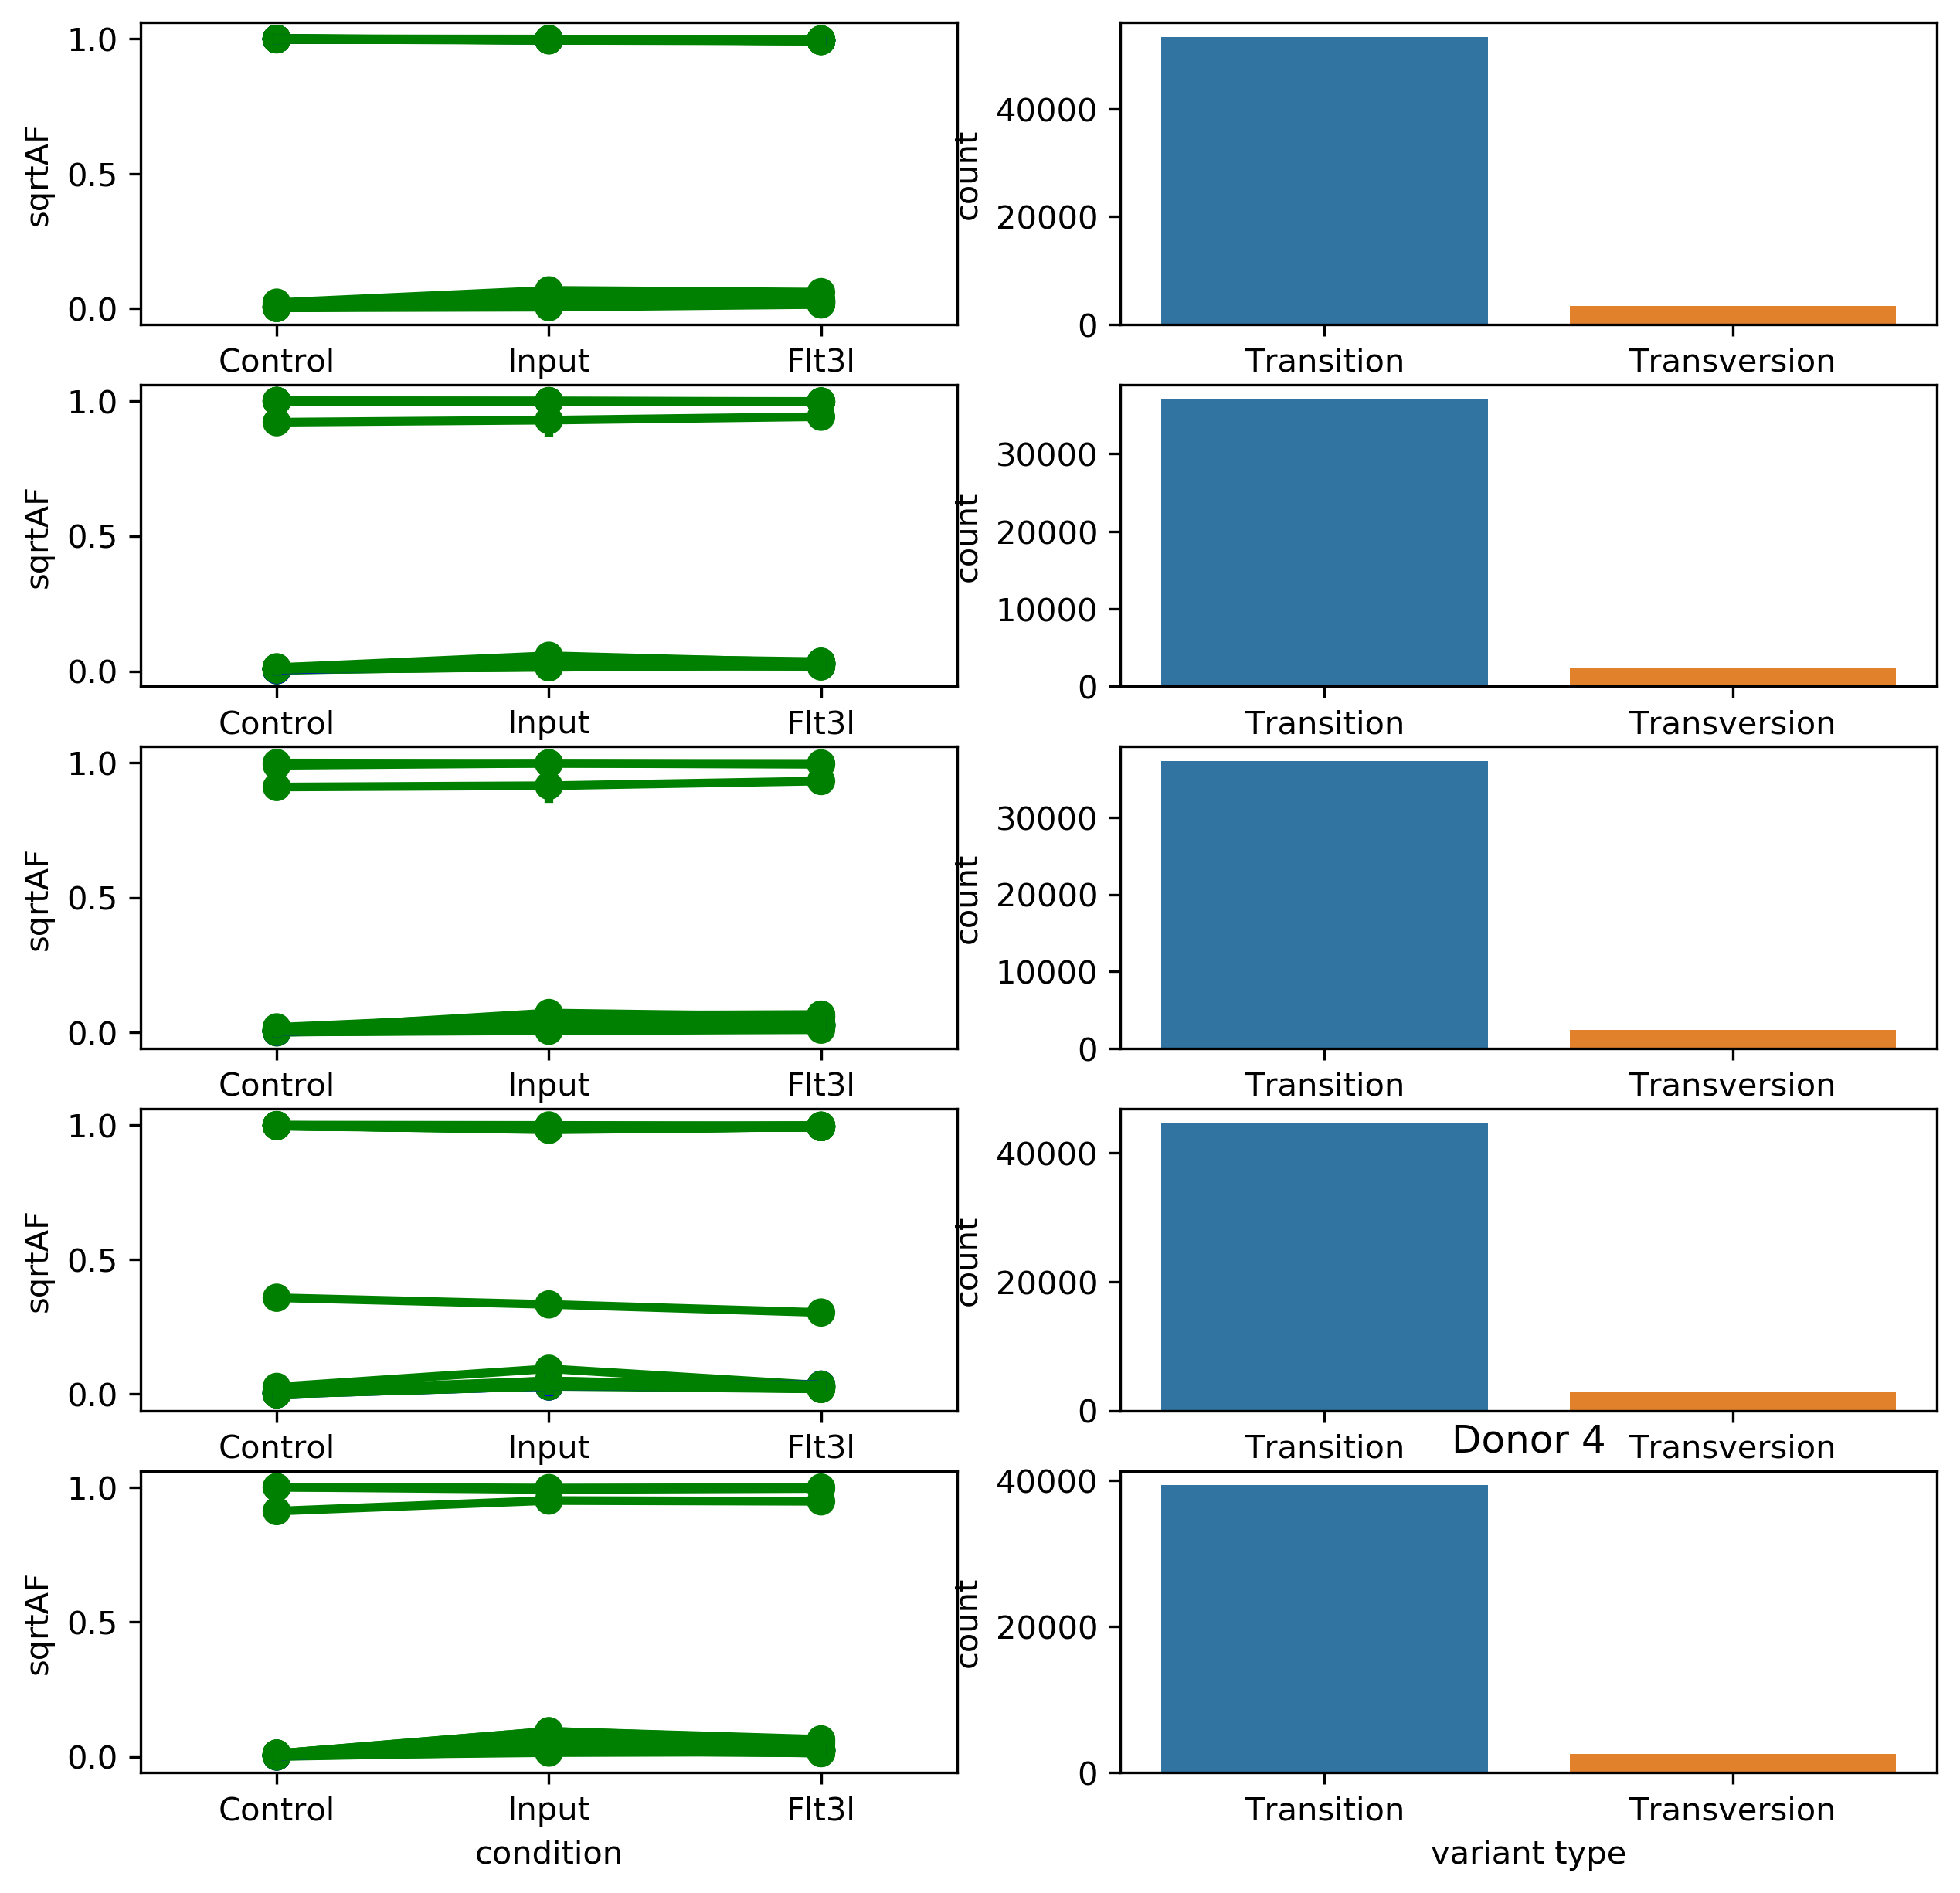

In [13]:
%matplotlib inline
#variants_box=variants_dense(AF_df, vars_to_plot)

if len(samples)<=2:
    order = samples
else:
    order = [samples[0], samples[-1]]+samples[1:-1]

colors={"Transition":"g", 'Transversion': 'b'}

f, ax = plt.subplots(len(set(variants_box['donor'])), 2, figsize=(10,10), dpi=300)
for d, df in variants_box.groupby("donor"):
    #f,ax = plt.subplots()
    for v, df2 in df.groupby("Variant"):
        sns.pointplot(x='condition', y='sqrtAF', order=order, data=df2, color=colors[df2["variant type"].iloc[0]],
                      ax=ax[d,0])
        sns.countplot(x=df['variant type'], ax=ax[d,1])
        
        #ax.legend().set_visible(False)

    plt.title(f"Donor {d}")

### Without input

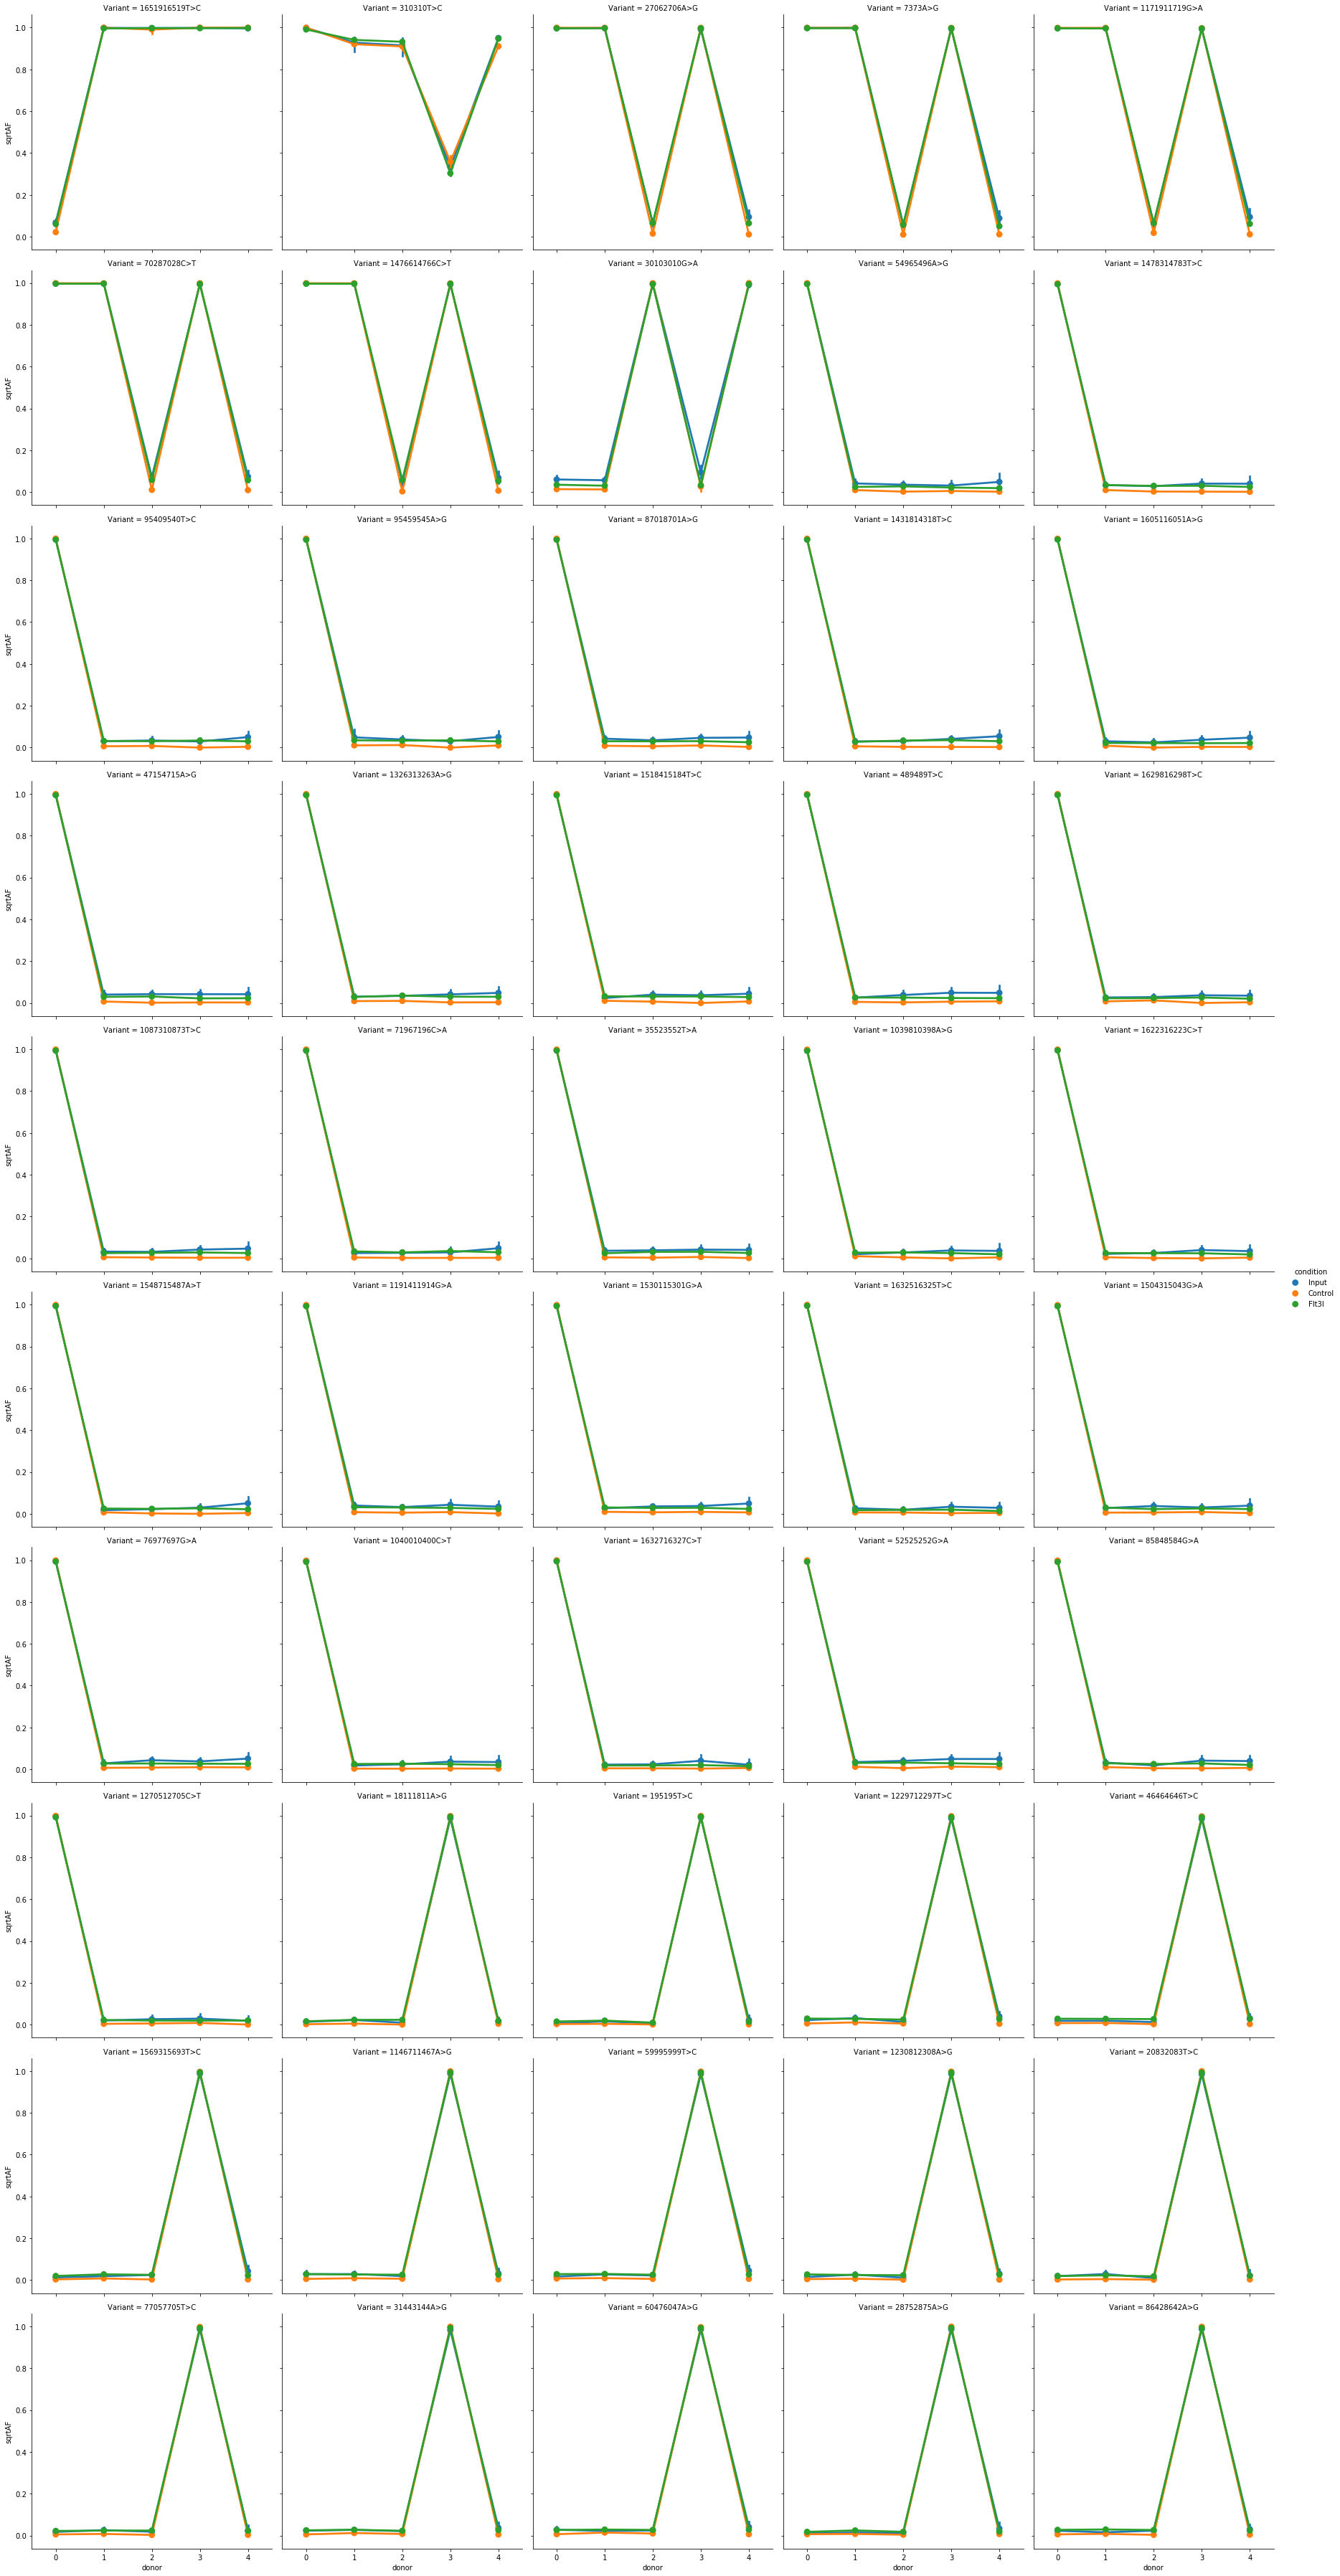

In [15]:
g = sns.catplot(x='donor', y='sqrtAF', 
                hue='condition', col='Variant',col_wrap=5, 
                data=variants_box, 
                kind="point", bw=.2)


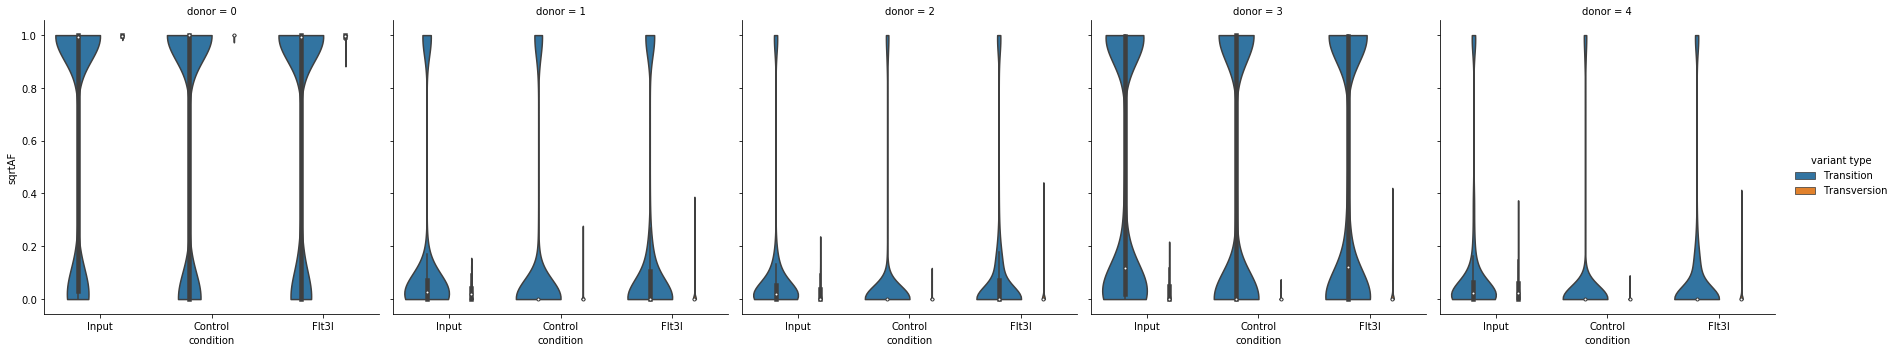

In [16]:
%matplotlib inline
#variants_box=variants_dense(AF_df, vars_to_plot)

g = sns.catplot(x='condition', y='sqrtAF', 
                hue='variant type', col='donor',col_wrap=5, 
                data=variants_box, 
                kind="violin", dodge=True, cut=0, bw=.2, scale="count")
